In [1]:
#install.packages("pdp")

In [2]:
options(repr.plot.width  = 15,
        repr.plot.height = 10)

In [3]:
# Helper packages
library(dplyr)       # for data wrangling
library(ggplot2)     # for awesome plotting

# Modeling packages
library(rpart)       # direct engine for decision tree application
library(caret)       # meta engine for decision tree application

# Model interpretability packages
library(rpart.plot)  # for plotting decision trees
library(vip)         # for feature importance



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice


Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




# Demostración de como elegir donde hacer split

## Regression

In [4]:
data  <- data.frame(x = c(1:10), y = c(3, 2, 2, 3, 5, 5, 6, 8, 9, 8))
data

x,y
<int>,<dbl>
1,3
2,2
3,2
4,3
5,5
6,5
7,6
8,8
9,9


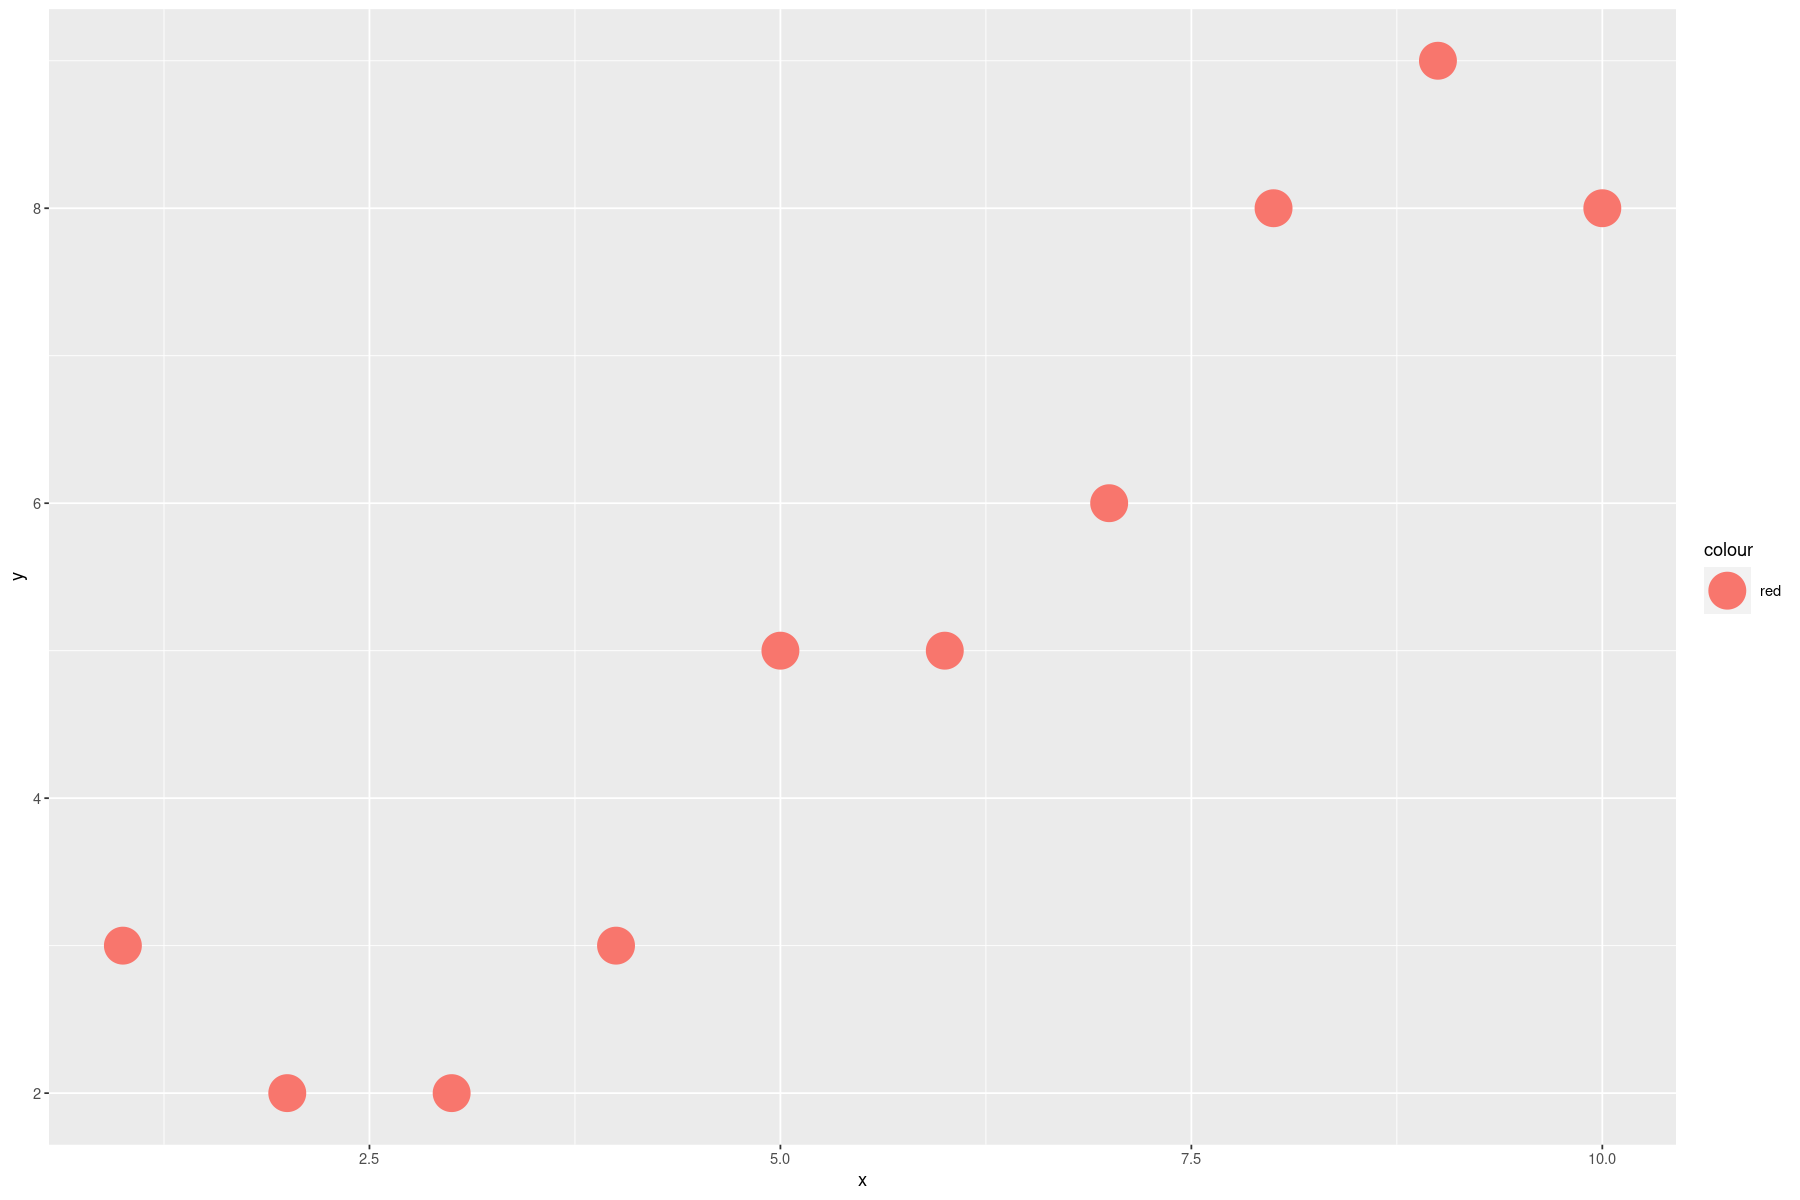

In [5]:
ggplot(data, aes(x=x, y=y, color="red")) + geom_point(size=10)

In [6]:
# Función para calcular la suma del error cuadratico
sse <- function(p1, p2){
  sse1 = sum((p1 - mean(p1))^2)
  sse2 = sum((p2 - mean(p2))^2)
  
  return(sse1 + sse2)
}

In [7]:
# una division manual
split1 = data$x <= 7
p1 = data[split1,]
p2 = data[!split1,]
sse(p1$y, p2$y)

[1] 16.09524

In [8]:
# iteracion por todos los valores de X para ver que valor genera el menos sse
for (k in 1:9) {
    split1 = data$x <= k
    p1 = data[split1,]
    p2 = data[!split1,]
    print(paste(k, sse(p1$y, p2$y)))
}

[1] "1 56"
[1] "2 44"
[1] "3 28.0952380952381"
[1] "4 15.8333333333333"
[1] "5 16.8"
[1] "6 14.0833333333333"
[1] "7 16.0952380952381"
[1] "8 32"
[1] "9 51.5555555555556"


In [9]:
# Mejor split
split1 = data$x <= 6
p1 = data[split1,]
p2 = data[!split1,]
sse(p1$y, p2$y)

[1] 14.08333

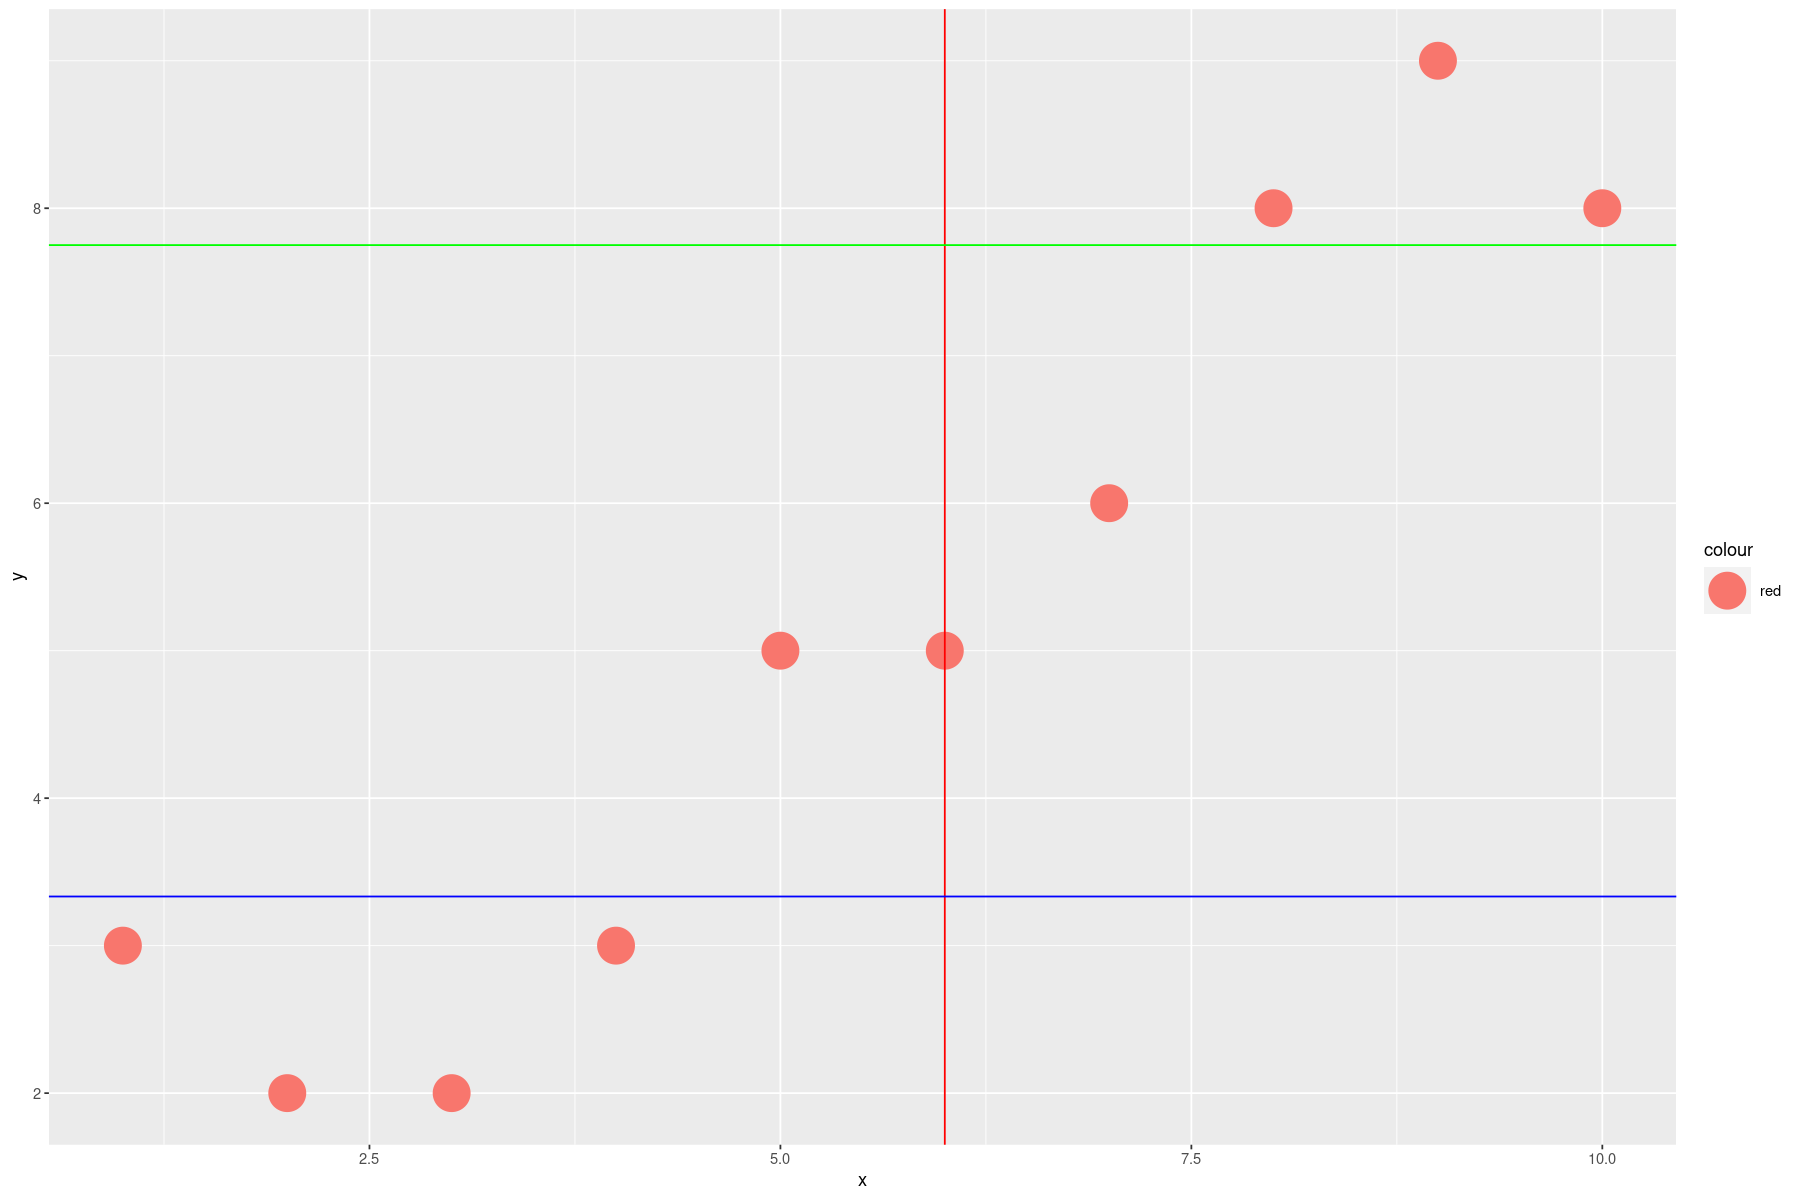

In [10]:
ggplot(data, aes(x=x, y=y, color="red")) +
    geom_point(size=10) + 
    geom_vline(xintercept = 6, color='red') + 
    geom_hline(yintercept = mean(p1$y), color='blue') + 
    geom_hline(yintercept = mean(p2$y), color='green')

In [11]:
# Repetir el mismo procedimiento pero ahora para la region de p1
for (k in 1:5) {
    split1 = p1$x <= k
    p1_1 = p1[split1,]
    p1_2 = p1[!split1,]
    print(paste(k, sse(p1_1$y, p1_2$y)))
}

[1] "1 9.2"
[1] "2 7.25"
[1] "3 3.33333333333333"
[1] "4 1"
[1] "5 6"


In [12]:
mean(p1$y)

[1] 3.333333

## Classification

<img src="https://hsto.org/webt/o4/nx/p7/o4nxp7itpg_zxowtmffs5xh3bbw.png">

In [13]:
data_class  <- data.frame(x = c(1:10), y = c(1, 1, 2, 2, 2, 2, 1, 1, 2, 2))
data_class

x,y
<int>,<dbl>
1,1
2,1
3,2
4,2
5,2
6,2
7,1
8,1
9,2


In [14]:
# Función para calcular la entropia
entropy <- function(data){
  p1 = mean(data == 1)
  p2 = mean(data == 2)
  result = -(p1 * log2(p1) + p2 * log2(p2))
  return(result)
}
# Función para calcular el indice de gini
gini <- function(data){
  p1 = mean(data == 1)
  p2 = mean(data == 2)
  result = 1 - (p1^2 + p2^2)
  return(result)
}
# Función para calcular la informacion ganada
information_gain  <- function(root, p1, p2){
    s0 = entropy(root)
    s1 = entropy(p1)
    s2 = entropy(p2)
    n0 = length(root)
    n1 = length(p1)
    n2 = length(p2)
    return (s0 - (n1*s1 + n2*s2)/n0)
}

split 0 - root node

In [15]:
s_0 = entropy(data_class$y)
s_0

[1] 0.9709506

In [16]:
split1 = data_class$x <= 7
p1 = data_class[split1,]
p2 = data_class[!split1,]
information_gain(data_class$y, p1$y, p2$y)

[1] 0.005802149

In [17]:
for (k in 1:9) {
    split1 = data_class$x <= k
    p1 = data_class[split1,]
    p1 = data_class[!split1,]
    print(paste(k, information_gain(data_class$y, p1$y, p2$y)))
}

[1] "1 -0.131004406410719"
[1] "2 0.0464393446710154"
[1] "3 0.09127744624168"
[1] "4 0.144484343805628"
[1] "5 0.209986547010987"
[1] "6 0.295461844238322"
[1] "7 0.419973094021975"
[1] "8 NaN"
[1] "9 NaN"


# Decision Tree - Regression

[Documentacion de rpart](https://cran.r-project.org/web/packages/rpart/vignettes/longintro.pdf)

Hiperparametros
* minsplit
* minbucket
* maxdepth
* cp 


## Load data

In [18]:
ames <- AmesHousing::make_ames()

In [19]:
dim(ames)

[1] 2930   81

## Split Data

In [20]:
index_2 <- createDataPartition(ames$Sale_Price, p = 0.7, 
                               list = FALSE, )
house_train <- ames[index_2, ]
house_test  <- ames[-index_2, ]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


## Modeling

In [21]:
ames_dt1 <- rpart(
  formula = Sale_Price ~ .,
  data    = house_train,
  method  = "anova",
  control = rpart.control(maxdepth=1)
)

In [22]:
ames_dt1

n= 2053 

node), split, n, deviance, yval
      * denotes terminal node

1) root 2053 1.312095e+13 180875.1  
  2) Overall_Qual=Very_Poor,Poor,Fair,Below_Average,Average,Above_Average,Good 1711 4.172084e+12 156459.0 *
  3) Overall_Qual=Very_Good,Excellent,Very_Excellent 342 2.825863e+12 303026.8 *

In [23]:
ames_dt1 <- rpart(
  formula = Sale_Price ~ .,
  data    = house_train,
  method  = "anova",
  minbucket = 5
)

In [24]:
ames_dt1

n= 2053 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 2053 1.312095e+13 180875.10  
   2) Overall_Qual=Very_Poor,Poor,Fair,Below_Average,Average,Above_Average,Good 1711 4.172084e+12 156459.00  
     4) Neighborhood=North_Ames,Old_Town,Edwards,Sawyer,Mitchell,Brookside,Iowa_DOT_and_Rail_Road,South_and_West_of_Iowa_State_University,Meadow_Village,Briardale,Northpark_Villa,Blueste 1037 1.402406e+12 132219.90  
       8) Overall_Qual=Very_Poor,Poor,Fair,Below_Average 178 1.306856e+11  95566.52 *
       9) Overall_Qual=Average,Above_Average,Good 859 9.830300e+11 139815.10  
        18) First_Flr_SF< 1150.5 602 3.581567e+11 130000.90 *
        19) First_Flr_SF>=1150.5 257 4.310691e+11 162803.90 *
     5) Neighborhood=College_Creek,Somerset,Northridge_Heights,Gilbert,Northwest_Ames,Sawyer_West,Crawford,Timberland,Northridge,Stone_Brook,Clear_Creek,Bloomington_Heights,Veenker,Green_Hills 674 1.222989e+12 193752.70  
      10) Gr_Liv_Area< 1757.5 480 4.836443e+11 177

node) | criterio | n_samples | sse | mean(y)

In [25]:
ames_dt1

n= 2053 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 2053 1.312095e+13 180875.10  
   2) Overall_Qual=Very_Poor,Poor,Fair,Below_Average,Average,Above_Average,Good 1711 4.172084e+12 156459.00  
     4) Neighborhood=North_Ames,Old_Town,Edwards,Sawyer,Mitchell,Brookside,Iowa_DOT_and_Rail_Road,South_and_West_of_Iowa_State_University,Meadow_Village,Briardale,Northpark_Villa,Blueste 1037 1.402406e+12 132219.90  
       8) Overall_Qual=Very_Poor,Poor,Fair,Below_Average 178 1.306856e+11  95566.52 *
       9) Overall_Qual=Average,Above_Average,Good 859 9.830300e+11 139815.10  
        18) First_Flr_SF< 1150.5 602 3.581567e+11 130000.90 *
        19) First_Flr_SF>=1150.5 257 4.310691e+11 162803.90 *
     5) Neighborhood=College_Creek,Somerset,Northridge_Heights,Gilbert,Northwest_Ames,Sawyer_West,Crawford,Timberland,Northridge,Stone_Brook,Clear_Creek,Bloomington_Heights,Veenker,Green_Hills 674 1.222989e+12 193752.70  
      10) Gr_Liv_Area< 1757.5 480 4.836443e+11 177

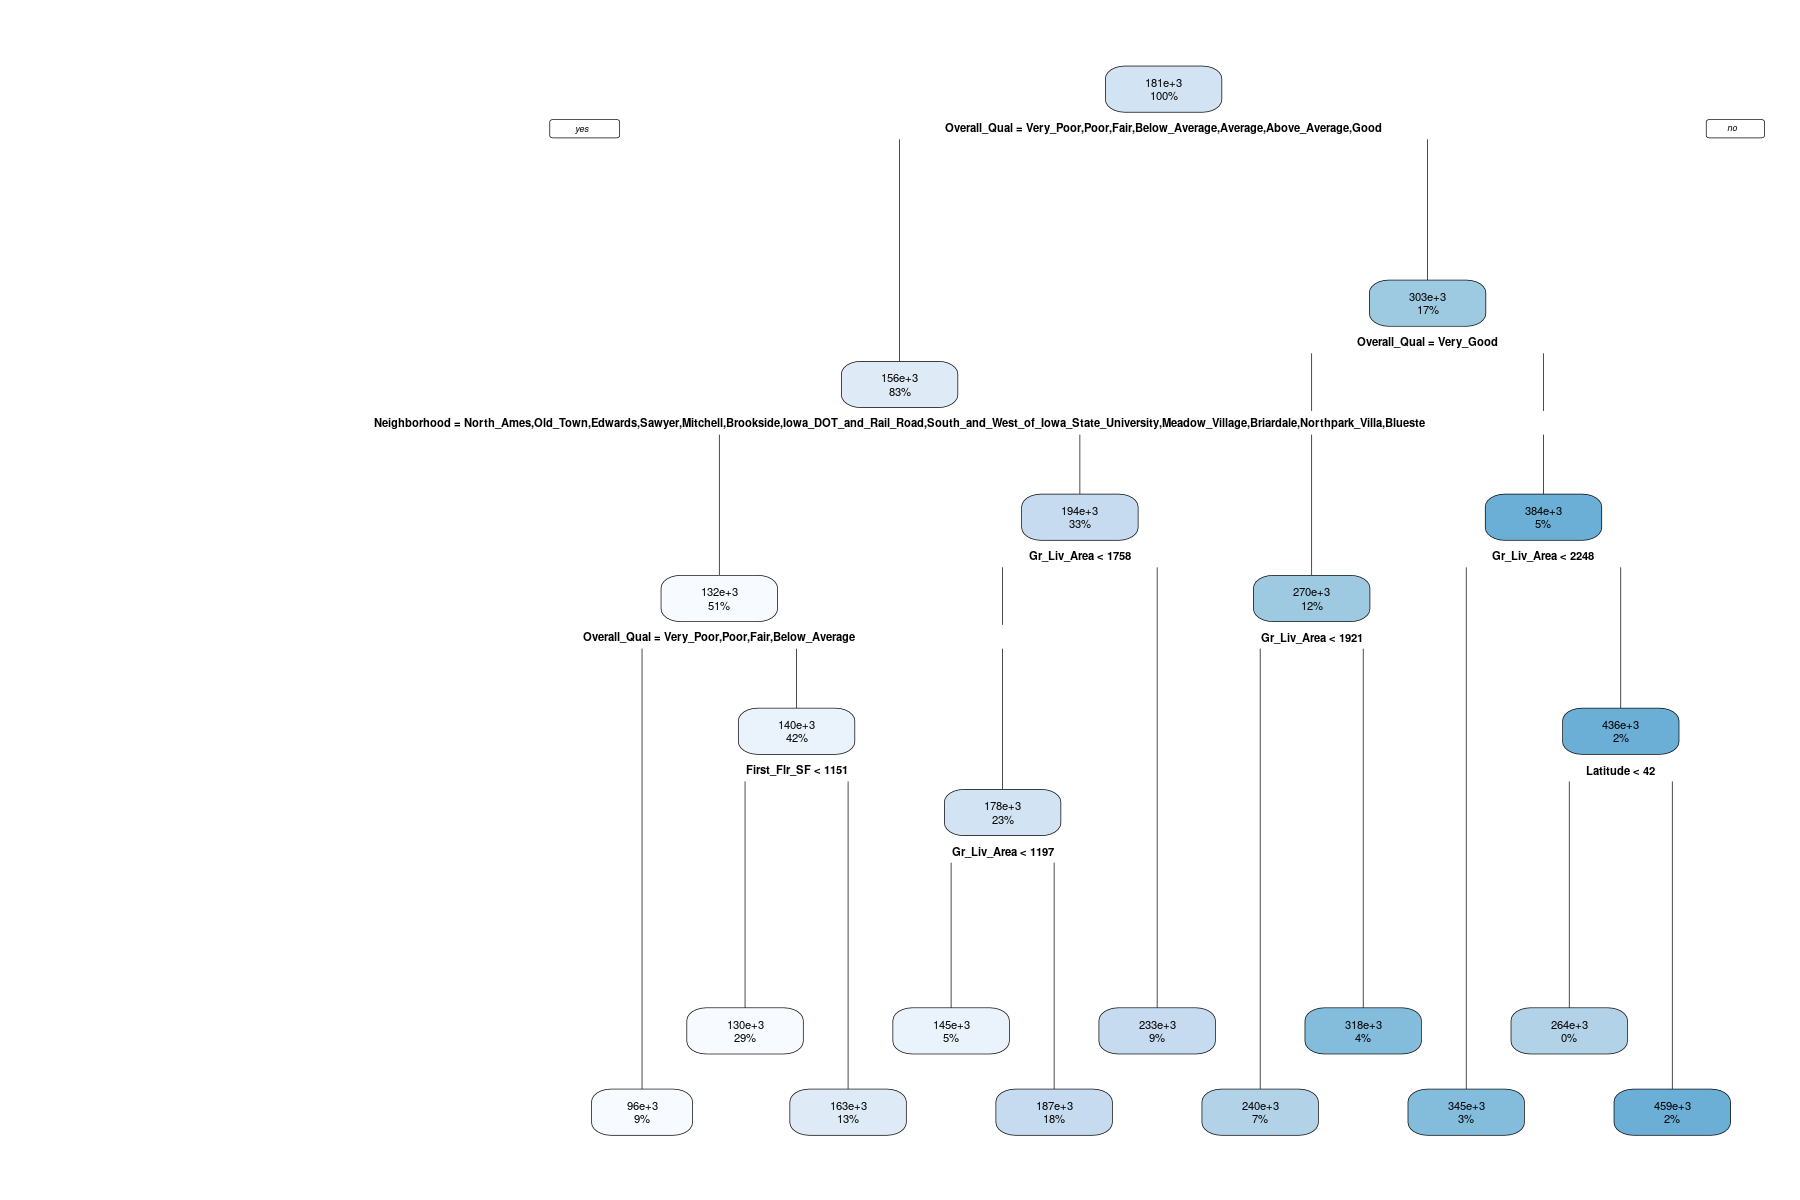

In [26]:
rpart.plot(ames_dt1)

### Diferentes valores de  cp (complexity parameter)

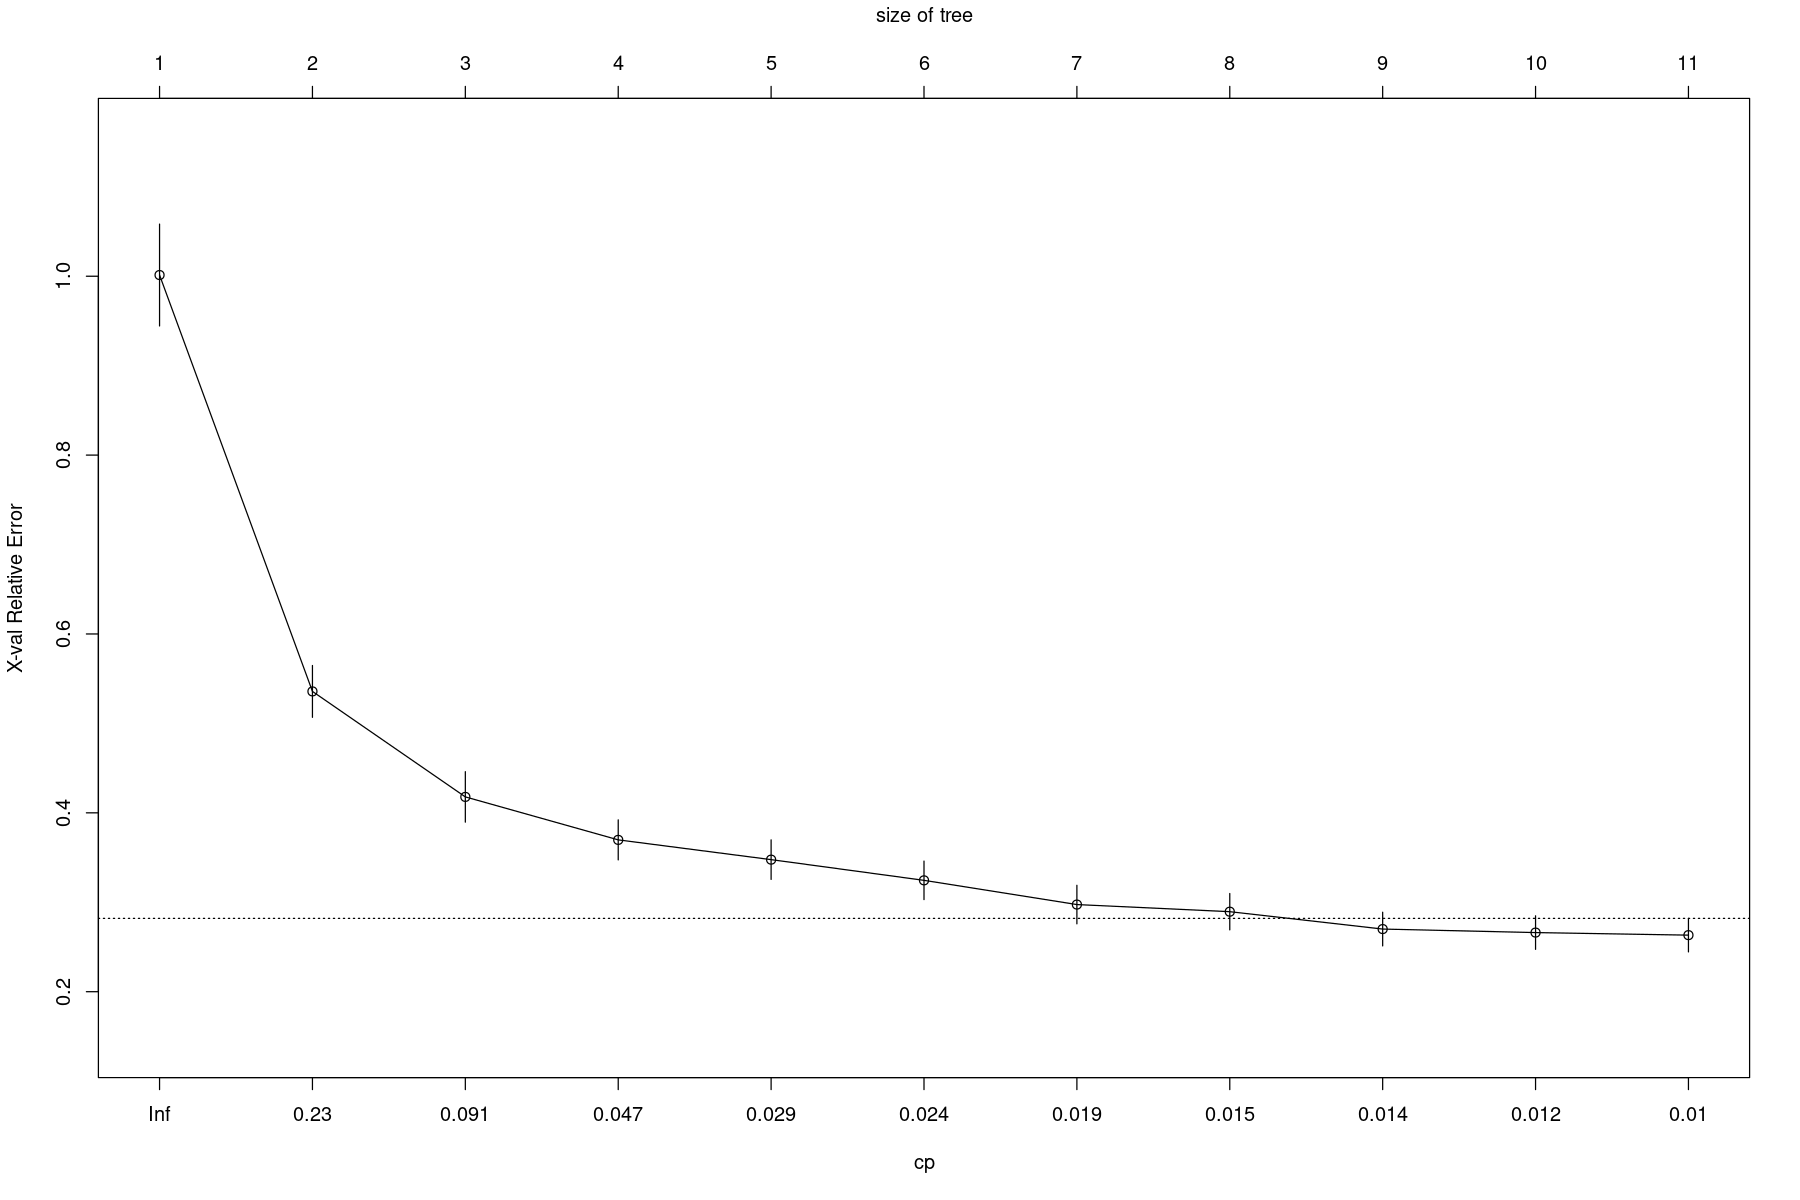

In [27]:
plotcp(ames_dt1)

Que pasa si queremos dejar que el arbol cresca sin restricciones?

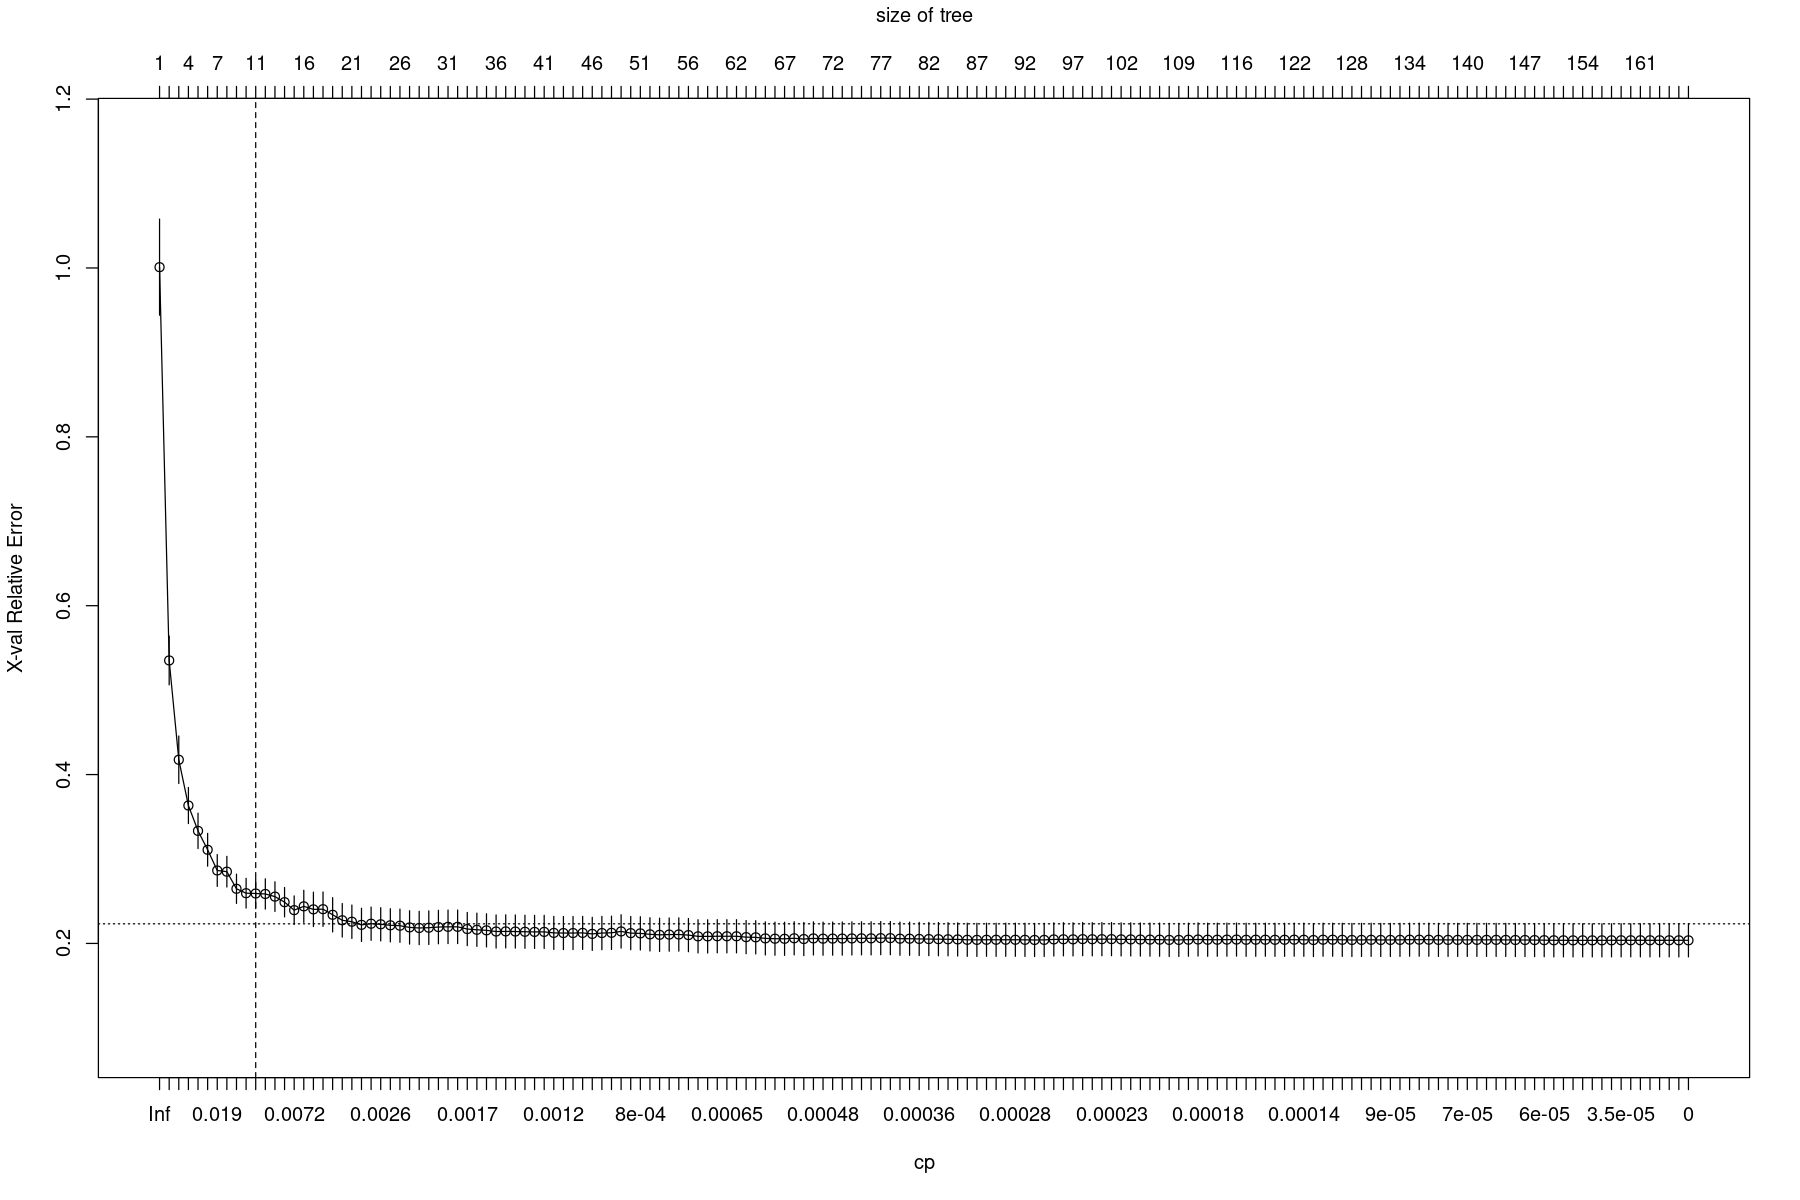

In [28]:
ames_dt2 <- rpart(
    formula = Sale_Price ~ .,
    data    = house_train,
    method  = "anova", 
    control = list(cp = 0, xval = 10)
)

plotcp(ames_dt2)
abline(v = 11, lty = "dashed")

Rpart no no tiene integrado otras metricas como RMSE para ellos vamos a usar Caret

In [29]:
# caret cross validation results
ames_dt3 <- train(
  Sale_Price ~ .,
  data = house_train,
  method = "rpart",
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 20  ## number of diferent cp values
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [30]:
ames_dt3

CART 

2053 samples
  80 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1847, 1846, 1848, 1849, 1848, 1847, ... 
Resampling results across tuning parameters:

  cp           RMSE      Rsquared   MAE     
  0.003942311  40711.21  0.7372526  27487.72
  0.004417013  40721.98  0.7365600  27683.18
  0.004541519  40940.28  0.7341108  27841.61
  0.005470895  41299.33  0.7295494  27971.28
  0.005958388  41980.08  0.7216685  28452.17
  0.006071956  42353.80  0.7175010  28694.50
  0.009030906  43707.89  0.6986251  30059.06
  0.010268906  44564.57  0.6861151  31056.31
  0.010476785  44564.57  0.6861151  31056.31
  0.010786728  44799.23  0.6824642  31263.99
  0.011297372  45217.39  0.6770049  31666.59
  0.015218302  45702.00  0.6708553  31976.40
  0.016920861  46010.20  0.6666591  32062.75
  0.022160147  48675.69  0.6257765  33926.15
  0.031481754  50940.52  0.5895887  35597.90
  0.033702061  51374.55  0.5824290  36131.97
  0.044829042  54258.10  0.533

A menor cp mayor es al profundidad del arbol y menor es el error, pero tambien aumente la probabilidad de hacer overfitting

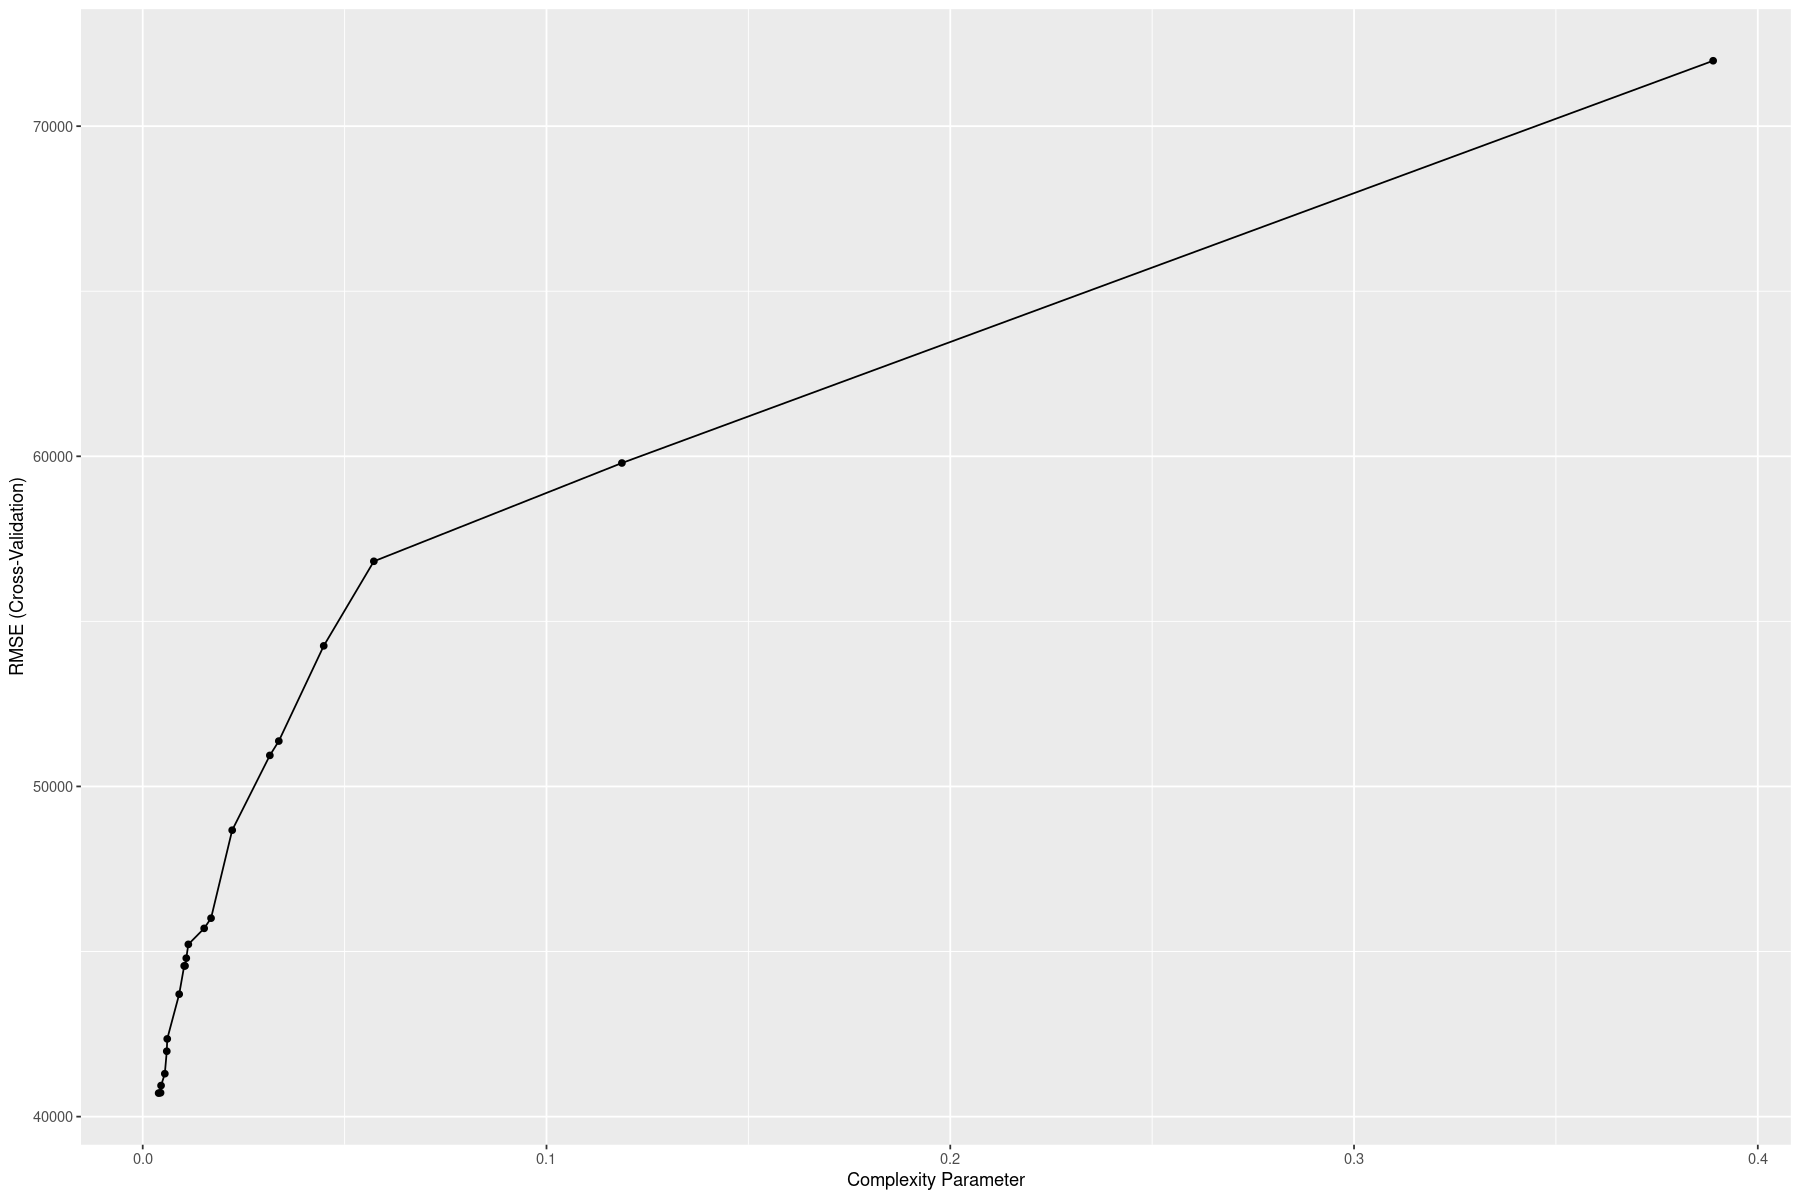

In [31]:
ggplot(ames_dt3)

## Feature importance
- La forma en la que se ponderan las variables se realiza sumando la reduccion en el error de cada split realizado usando una de las variables, dado que una misma variables se podria usar mas de una vez para hacer un split.
- Los abroles automaticamente hacen feaute selection para las variables poco informativas

Warning message in vip.default(ames_dt3, num_features = 40, bar = FALSE):
“The `bar` argument has been deprecated in favor of the new `geom` argument. It will be removed in version 0.3.0.”


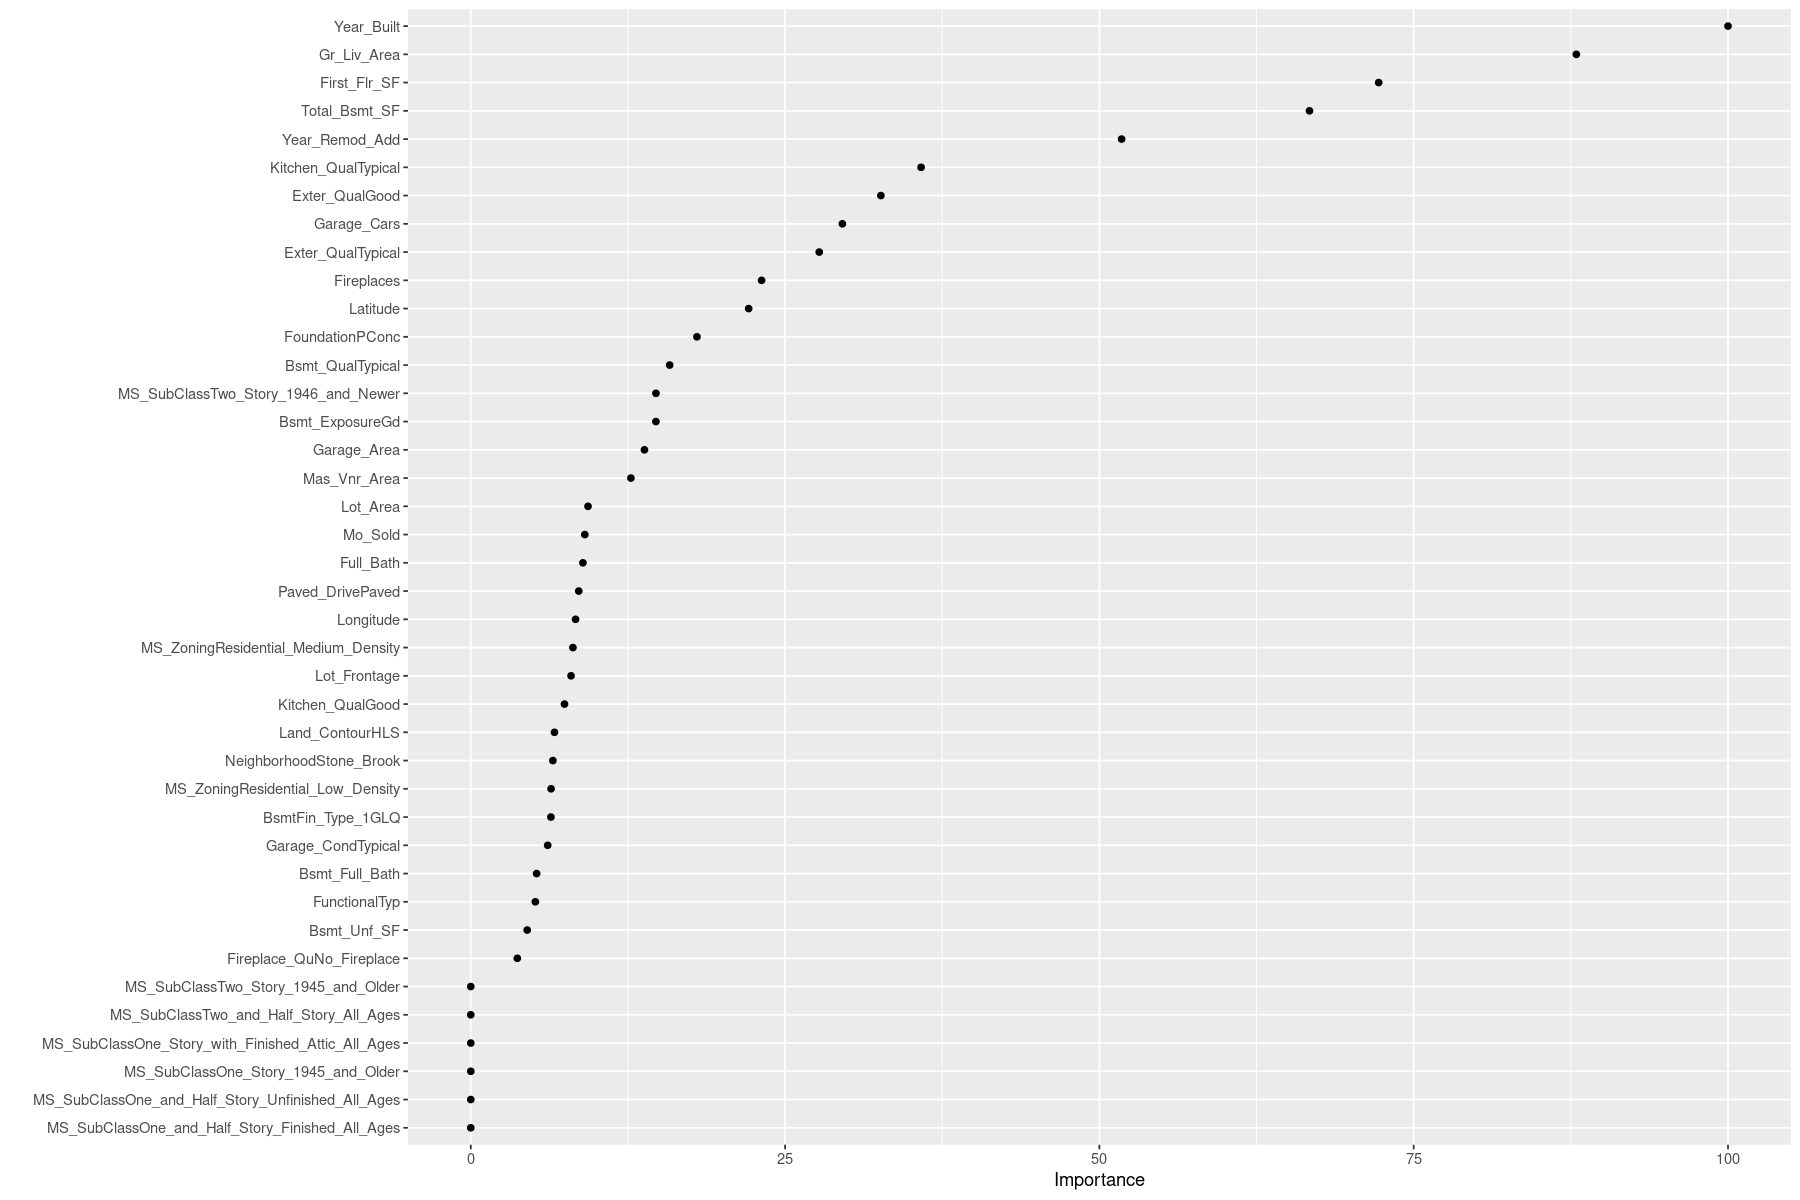

In [32]:
vip(ames_dt3, num_features = 40, bar = FALSE)

# Decision Tree - Classification

Por defecto rpart valancea las clases segun la proporcion de cada una de ellas en el global (class weight)
* parms = list(prior = c(p1, 1 - p1)
* parms = list(split = 'information'), 

## Load Data

In [33]:
data("attrition", package = "modeldata")
# Job attrition data
attrition <- attrition %>% 
  mutate_if(is.ordered, .funs = factor, ordered = FALSE)

## Split Data

In [34]:
index_caret <- createDataPartition(attrition$Attrition, p = 0.7, list = FALSE)
attrition_train <- attrition[index_caret, ]
attrition_test  <- attrition[-index_caret, ]

## Modeling

In [35]:
attrition_tree <- rpart(
  formula = Attrition ~ .,
  data    = attrition_train,
  method  = "class"
)

In [36]:
attrition_tree

n= 1030 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 1030 166 No (0.83883495 0.16116505)  
    2) OverTime=No 736  78 No (0.89402174 0.10597826)  
      4) TotalWorkingYears>=1.5 688  60 No (0.91279070 0.08720930) *
      5) TotalWorkingYears< 1.5 48  18 No (0.62500000 0.37500000)  
       10) JobRole=Research_Scientist 14   0 No (1.00000000 0.00000000) *
       11) JobRole=Human_Resources,Laboratory_Technician,Sales_Representative 34  16 Yes (0.47058824 0.52941176)  
         22) MaritalStatus=Divorced,Married 19   5 No (0.73684211 0.26315789) *
         23) MaritalStatus=Single 15   2 Yes (0.13333333 0.86666667) *
    3) OverTime=Yes 294  88 No (0.70068027 0.29931973)  
      6) MonthlyIncome>=3751.5 194  32 No (0.83505155 0.16494845)  
       12) JobRole=Healthcare_Representative,Human_Resources,Laboratory_Technician,Manager,Manufacturing_Director,Research_Director,Research_Scientist,Sales_Representative 141  12 No (0.91489362 0.08510638) *
       

### Visualizacion del arbol de decisión

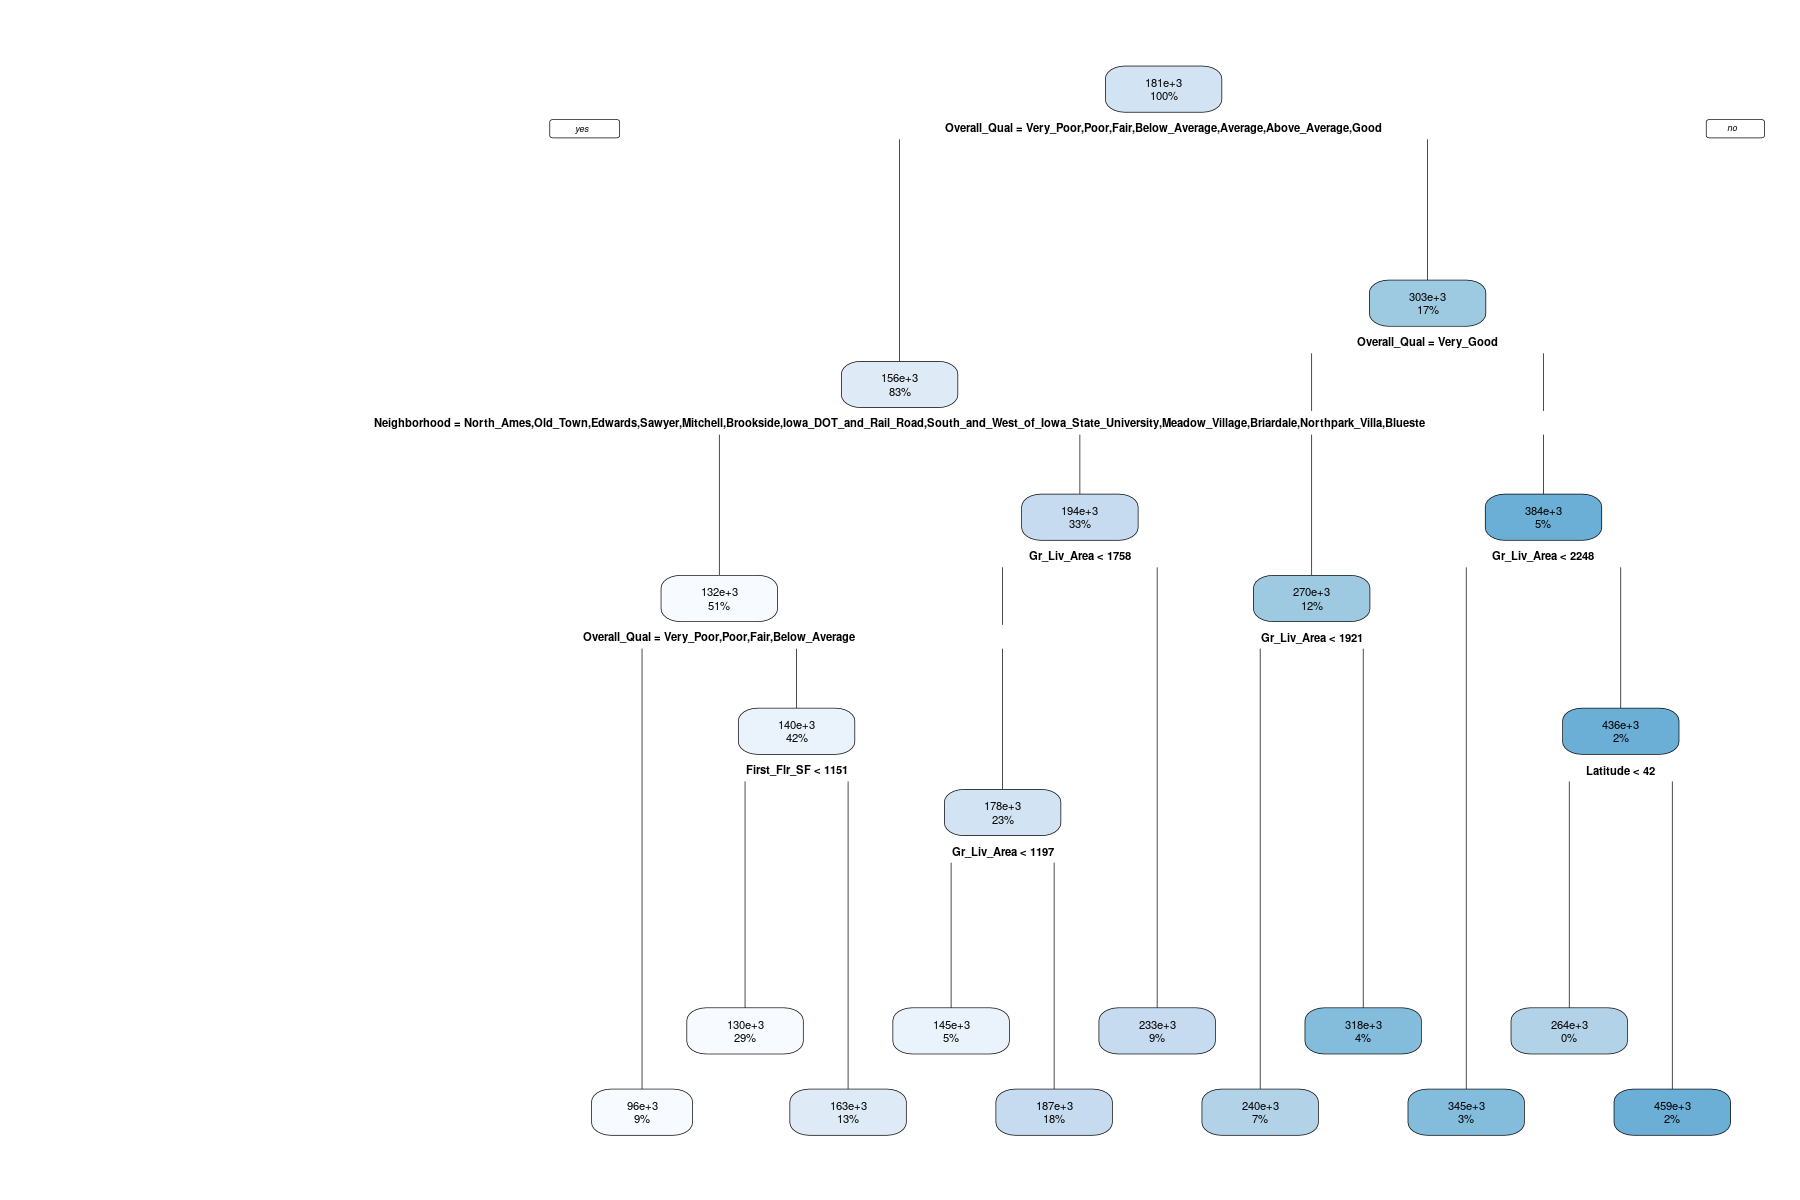

In [37]:
rpart.plot(ames_dt1)

## Evaluación del modelo

In [38]:
pred_train_class <- predict(attrition_tree, attrition_train, type = "class")
confusionMatrix(
  data = relevel(pred_train_class, ref = "Yes"), 
  reference = relevel(attrition_train$Attrition, ref = "Yes"),
  mode='prec_recall'
)

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes  79  20
       No   87 844
                                          
               Accuracy : 0.8961          
                 95% CI : (0.8759, 0.9141)
    No Information Rate : 0.8388          
    P-Value [Acc > NIR] : 8.503e-08       
                                          
                  Kappa : 0.5409          
                                          
 Mcnemar's Test P-Value : 1.766e-10       
                                          
              Precision : 0.79798         
                 Recall : 0.47590         
                     F1 : 0.59623         
             Prevalence : 0.16117         
         Detection Rate : 0.07670         
   Detection Prevalence : 0.09612         
      Balanced Accuracy : 0.72638         
                                          
       'Positive' Class : Yes             
                                          

## Evaluar el performance del modelo definiendo manualmente los hiperparametros

In [39]:
attrition_tree <- rpart(
  formula = Attrition ~ .,
  data    = attrition_train,
  method  = "class",
    control = rpart.control(maxdepth=4)
)
pred_train_class <- predict(attrition_tree, attrition_train, type = "class")
confusionMatrix(
  data = relevel(pred_train_class, ref = "Yes"), 
  reference = relevel(attrition_train$Attrition, ref = "Yes"),
  mode='prec_recall'
)

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes  74  26
       No   92 838
                                          
               Accuracy : 0.8854          
                 95% CI : (0.8644, 0.9042)
    No Information Rate : 0.8388          
    P-Value [Acc > NIR] : 1.369e-05       
                                          
                  Kappa : 0.4952          
                                          
 Mcnemar's Test P-Value : 2.181e-09       
                                          
              Precision : 0.74000         
                 Recall : 0.44578         
                     F1 : 0.55639         
             Prevalence : 0.16117         
         Detection Rate : 0.07184         
   Detection Prevalence : 0.09709         
      Balanced Accuracy : 0.70785         
                                          
       'Positive' Class : Yes             
                                          